### Raster overlay

this notebook shows how to plot on top of an rgb png file created with plot_tiff.ipynb

In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as image
import matplotlib
import rasterio
from e582lib.map_slices import get_basemap
import numpy as np
from mpl_toolkits.basemap import Basemap
from e582utils.data_read import download
import warnings
warnings.filterwarnings("ignore")

In [2]:
download('stretched_rgb.png')
download('stretched_rgb.tif')


stretched_rgb.png already exists
and is 9513159 bytes
will not overwrite


stretched_rgb.tif already exists
and is 45040718 bytes
will not overwrite



#### Read in the png 3-color image along with the tif version and save the projection and transform

In [3]:
imfile = 'stretched_rgb.png'
im=image.imread(imfile)
#
# find all black pixels and turn  them light grey
#
hit = np.logical_and(im[:,:,0]==0, im[:,:,1]==0,im[:,:,2]==0)
im[hit,:]=0.75
#
# now get the projeciton information and create a basemap
#
tiffile='stretched_rgb.tif'
with rasterio.open(tiffile,'r') as src:
    plot_dict=dict(src.profile)
    chancount=plot_dict['count']
width=plot_dict['width']
height=plot_dict['height']
crs = dict(plot_dict['crs'])
transform = plot_dict['transform']
cmap=matplotlib.cm.get_cmap('magma')
basemap_args, xvals, yvals = get_basemap(width,height,crs,transform)
#
# save the easting and northing so we can zoom the image below
#
bmap=Basemap(**basemap_args)
east,north=bmap.projparams['x_0'],bmap.projparams['y_0']

#### draw the full png

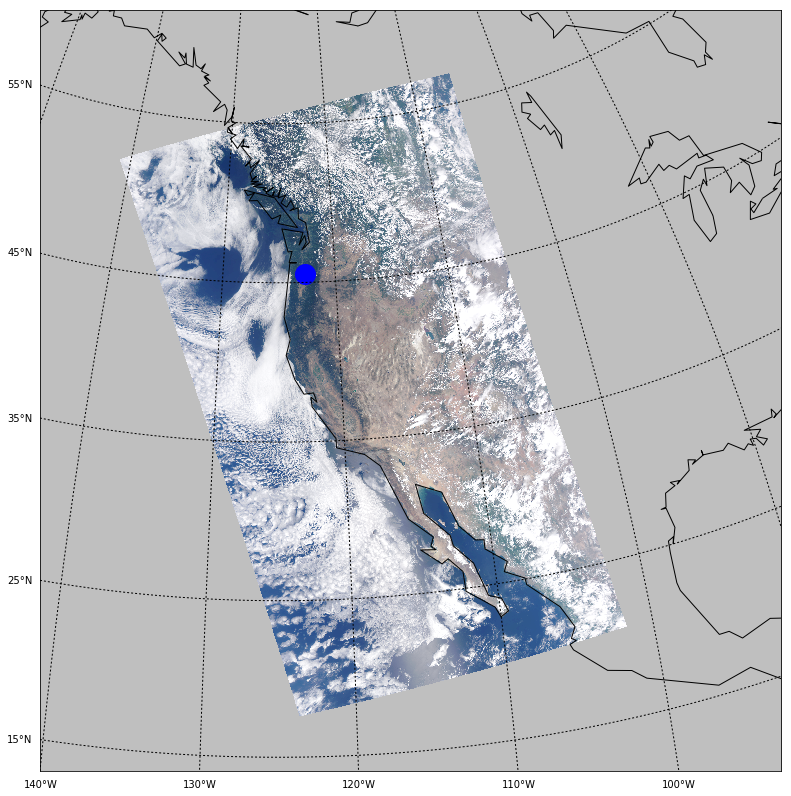

In [4]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(18,14))
basemap_args['ax']=ax
basemap_args['resolution']='c'
bmap=Basemap(**basemap_args)
bmap.imshow(im,origin='upper')
bmap.drawcoastlines();
port_lon,port_lat=(-122.6765,45.5231)
port_x,port_y = bmap(port_lon,port_lat)
bmap.plot(port_x,port_y,'bo',markersize=20);
parallels=np.arange(15, 60, 10)
meridians=np.arange(-150, -80, 10)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);

#### now zoom in on the northwest

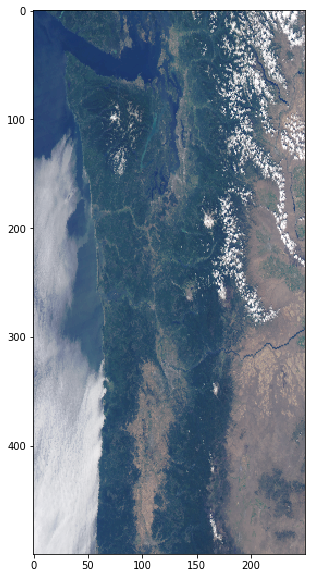

In [5]:
slicecols=slice(950,1200)
slicerows=slice(1400,1900)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(im[slicerows,slicecols,:],origin='upper');

#### to create a map, we will need to get a new transform using the corners of this slice

In [6]:
# need to remove the basemap easting and northing before
# we create the transform, to get properly zeroed xvals and yvals
#
zoom_im=im[slicerows,slicecols,:]
zoom_x, zoom_y = xvals[slicerows,slicecols] - east ,yvals[slicerows,slicecols] - north
height,width,_ = zoom_im.shape
# 
# get the lower left and upper right x,y coords for the transform
#
ll_x,ll_y=zoom_x[-1,0],zoom_y[-1,0]
ur_x,ur_y=zoom_x[0,-1],zoom_y[0,-1]
from rasterio.transform import from_bounds
zoom_transform = from_bounds(ll_x, ll_y, ur_x, ur_y, width, height)
zoom_args, zoom_xvals, zoom_yvals = get_basemap(width,height,crs,zoom_transform)

#### now make a map with that transform and the old crs

make it semitransparent by setting the alpha

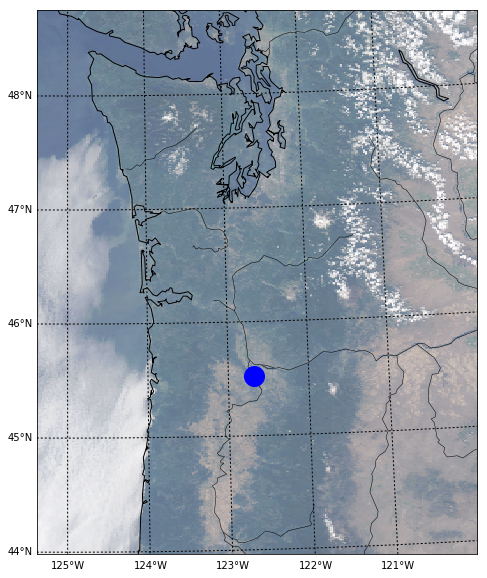

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
#
zoom_args['ax']=ax
zoom_args['resolution']='i'
bmap=Basemap(**zoom_args)
bmap.imshow(zoom_im,origin='upper',alpha=0.7)
bmap.drawcoastlines();
bmap.drawrivers()
port_lon,port_lat=(-122.6765,45.5231)
port_x,port_y = bmap(port_lon,port_lat)
bmap.plot(port_x,port_y,'bo',markersize=20);
parallels=np.arange(40, 50, 1)
meridians=np.arange(-130, -120, 1)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);